In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.tiny_image_net_data_module import TinyImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [2]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [3]:
data_dir = "../data"

dm = TinyImageNetDataModule(
    data_dir=os.path.join(data_dir, "tiny-imagenet-200"), 
    batch_size_train=64,
    batch_size_val=64,
    batch_size_test=64,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True,
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True, reconstruction_loss_weight = 0.5, adversarial_loss_weight = 0.5)

## Or load it from a checkpoint

In [ ]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/tiny_imagenet_same_losses_coefficients/2024-12-18_09-01-57-epoch=25-val_loss=1.46.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

## Train it

In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/tiny_imagenet_same_losses_coefficients',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Display some images and evaluate the model performances

Here the results of this cell are after 26 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64

- **Number of steps**: 5 000
- **Time**: 1h
- **Observation (with tensorboard)**: The results are similar to the paper, it's like we are putting a really sharp, detailled image inside it but without considering the context enough, the colors... So it's stands out and the results are bad.

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:03<00:00, 44.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           11.563889503479004
        test_loss           1.1253254413604736
        test_psnr           11.560413360595703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


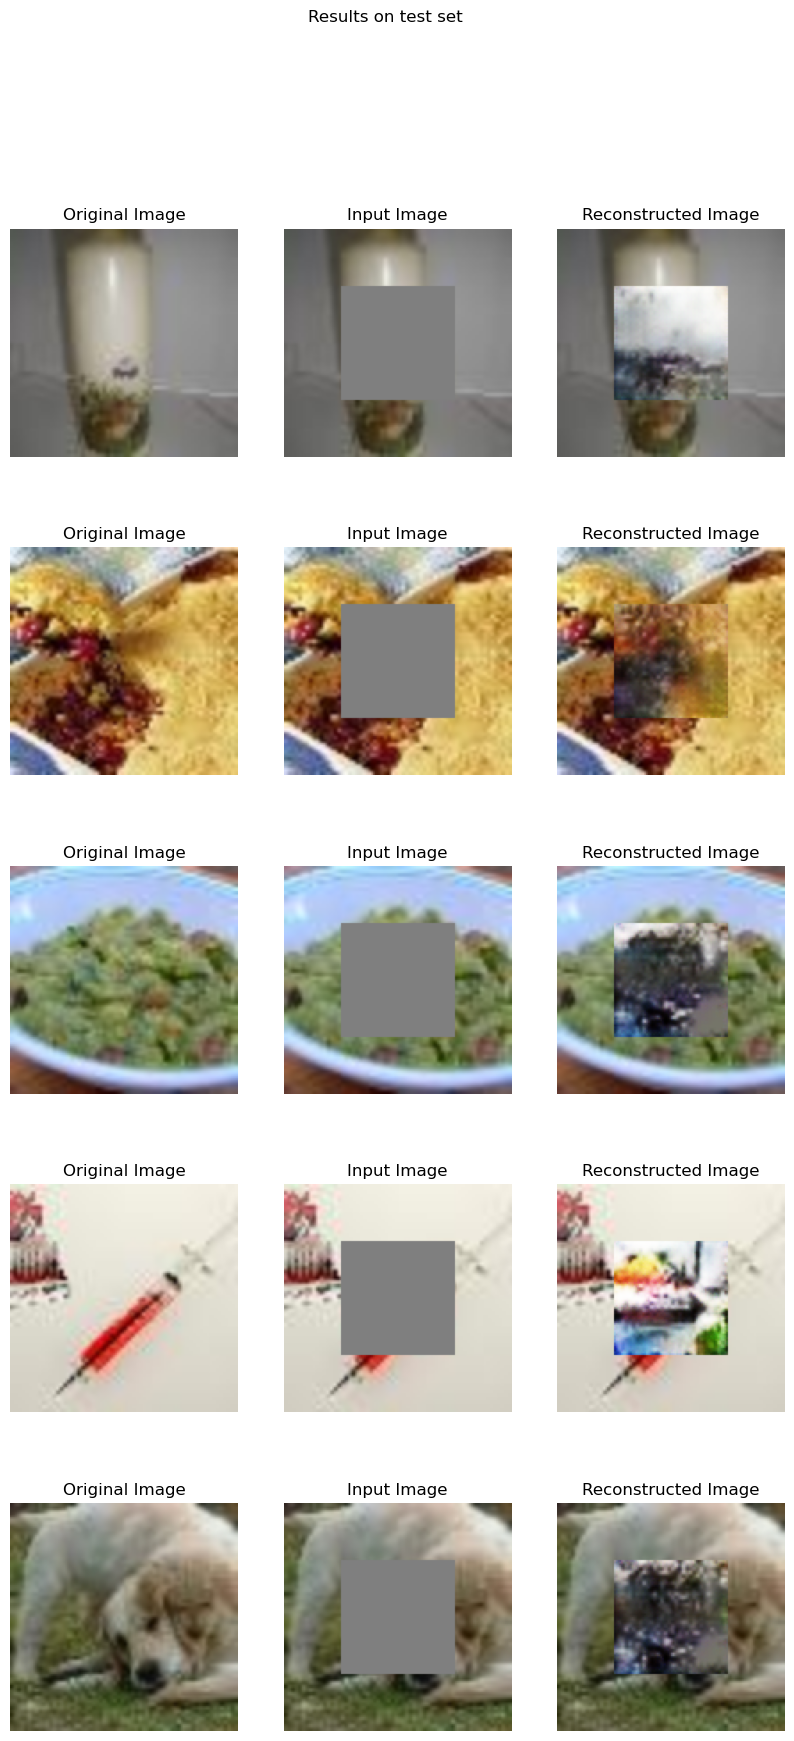

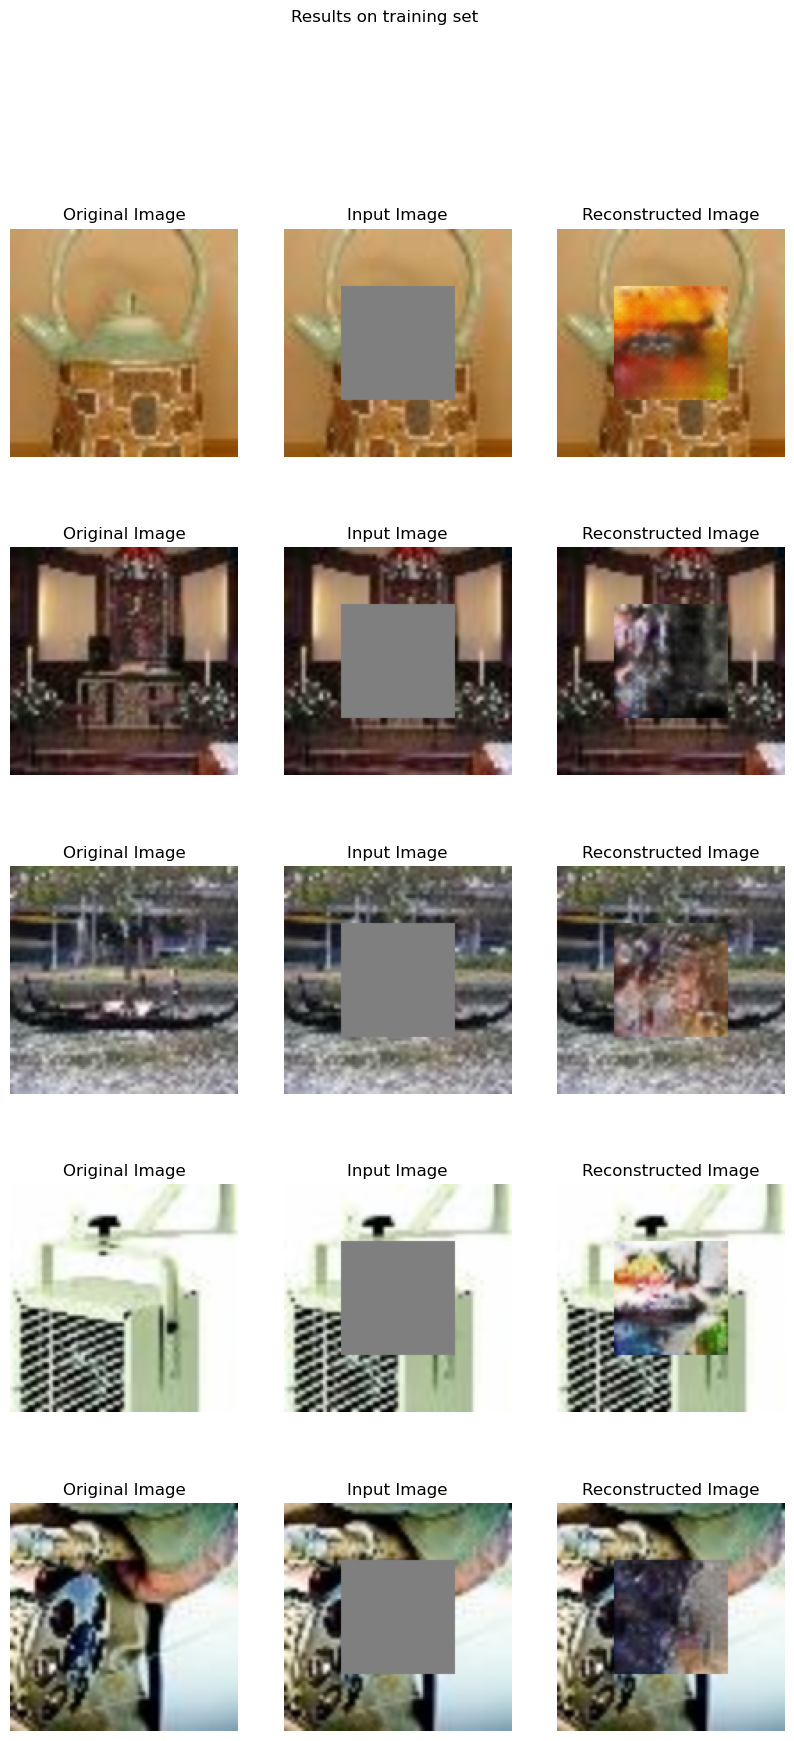

In [7]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)